## Table of Contents:
1. [Imports / Loading](#imports-loading)
2. [Voting Graph](#voting-graph)
3. [Agreement Graph](#agreement-graph)
4. [Similarity Graph](#similarity-graph)

### Imports / Loading <a class="anchor" id="imports-loading"></a>

In [1]:
# Put all imports here
import importlib
import pandas as pd
import modules.data_processing
import matplotlib.pyplot as plt
import networkx as nx
import random
from tqdm import tqdm
import seaborn as sns
from scipy.stats import f_oneway

In [2]:
## Reloading, rerun this cell if you change any function

importlib.reload(modules.data_processing)
from modules.data_processing import *

In [3]:
DATA_PATH = './data/wiki-RfA.txt'
EDITORS_PATH = './data/top_editors.txt'
AUTHORS_PATH = './data/top_authors.txt'
CREATORS_PATH = './data/top_creators.txt'
TALKS_DF = './data/talks_df.csv'

In [4]:
wiki_df = extract_data(DATA_PATH)
process_dataframe(wiki_df)

In [5]:
voters_df = create_voters_df(wiki_df)

### Voting Graph <a class="anchor" id="voting-graph"></a>

Within our dataset, we observe three distinct types of votes: Positive (+1), Neutral (0), and Negative (-1). As a result, it's important to distinguish between the three types of votes.

Another important thing is that we have seen that the nature of voters change from year to year, therefore, instead of creating a single graph for all the years, we create a graph for each successive two-year period.

At first, we only look at positive votes.

In [6]:
filtered_wiki_df = wiki_df[wiki_df['VOT'] == 1]
filtered_wiki_df['YEA'] = pd.to_datetime(filtered_wiki_df['YEA'], format='%Y')
filtered_wiki_df = filtered_wiki_df.sort_values(by='YEA', ascending=False)

#Create graphs for successive three-year periods
years = filtered_wiki_df['YEA'].dt.year.unique()
graphs = []

for i in range(len(years) - 1):
    current_years = years[i:i + 2]  #Get three successive years
    
    #Filter dataframe for the current three-year period
    current_period_df = filtered_wiki_df[filtered_wiki_df['YEA'].dt.year.isin(current_years)]
    
    #Create graph
    G = nx.from_pandas_edgelist(current_period_df, 'SRC', 'TGT', edge_attr=None, create_using= nx.Graph())
        
    graphs.append(G)

C:\Users\Akram\AppData\Local\Temp\ipykernel_50688\1941898036.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_wiki_df['YEA'] = pd.to_datetime(filtered_wiki_df['YEA'], format='%Y')


In [7]:
for i in range(len(years) - 1):
    current_years = years[i:i + 2]
    current_graph = graphs[i]
    
    print('Year :', current_years)
    
    print('Number of nodes:', current_graph.number_of_nodes())
    print('Number of edges:', current_graph.number_of_edges())
    print('Graph density:', nx.density(current_graph))
    print('Average clustering coefficient:', nx.average_clustering(current_graph))
    print('Graph Transitivity:', nx.transitivity(current_graph))
    
    
    
    print()

Year : [2013 2012]
Number of nodes: 1221
Number of edges: 6909
Graph density: 0.009276191243404359
Average clustering coefficient: 0.21527580336621377
Graph Transitivity: 0.1227589077487161

Year : [2012 2011]
Number of nodes: 1658
Number of edges: 10479
Graph density: 0.007628564127912944
Average clustering coefficient: 0.2281381925942787
Graph Transitivity: 0.13635027288900503

Year : [2011 2010]
Number of nodes: 2014
Number of edges: 15425
Graph density: 0.0076094265131659115
Average clustering coefficient: 0.20303031231985688
Graph Transitivity: 0.15948296655952038

Year : [2010 2009]
Number of nodes: 2617
Number of edges: 23191
Graph density: 0.0067749798716694775
Average clustering coefficient: 0.16993916380314503
Graph Transitivity: 0.15688589389597027

Year : [2009 2008]
Number of nodes: 3493
Number of edges: 34445
Graph density: 0.00564785273377716
Average clustering coefficient: 0.14822090195057416
Graph Transitivity: 0.1455719877303305

Year : [2008 2007]
Number of nodes: 46

The graph density and transitivity values being close to 0 suggest that the networks are very sparse.

In [8]:
user_nodes = []
degree_centrality = []
betweenness_centrality = []

for G in tqdm(graphs, desc='Calculating centrality measures'):
    #Calculate centrality measures for each graph
    degree = nx.degree_centrality(G)
    betweenness = nx.betweenness_centrality(G)
    
    #Update lists with maximum centrality values for each user node
    for user in G.nodes():
        user_nodes.append(user)
        degree_centrality.append(degree[user])
        betweenness_centrality.append(betweenness[user])

data = {
    'User': user_nodes,
    'Max_Degree_Centrality': degree_centrality,
    'Max_Betweenness_Centrality': betweenness_centrality
}

centrality_df = pd.DataFrame(data)

#Group by 'User' and get the maximum centrality values
centrality_df = centrality_df.groupby('User').max().reset_index()

Calculating centrality measures: 100%|█████████████████████████████████████████████████| 10/10 [11:00<00:00, 66.05s/it]


In [9]:
centrality_df

,User,Max_Degree_Centrality,Max_Betweenness_Centrality
0,!---slappdash---!,0.000382,0.000000
1,%D0%90,0.003002,0.000004
2,'sed,0.000751,0.000004
3,(.Y.),0.000250,0.000000
4,(:Julien:),0.000488,0.000000
...,...,...,...
10014,‎Jetijonez,0.000820,0.000000
10015,とある白い猫,0.000820,0.000000
10016,シ,0.001987,0.000005
10017,石,0.000820,0.000000


In [10]:
centrality_df.describe()

,Max_Degree_Centrality,Max_Betweenness_Centrality
count,10019.000000,10019.000000
mean,0.009077,0.001261
std,0.018144,0.004729
min,0.000214,0.000000
25%,0.000428,0.000000
50%,0.001207,0.000001
75%,0.009636,0.000392
max,0.244878,0.167773


In [11]:
louvain_communities = [nx.community.louvain_communities(G) for G in graphs]

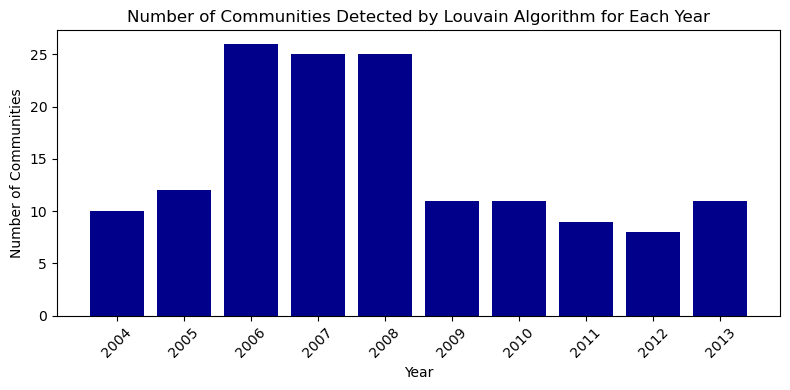

In [12]:
num_communities = [len(communities) for communities in louvain_communities]

plt.figure(figsize=(8, 4))
plt.bar(years[:-1], num_communities, color='darkblue')
plt.xlabel('Year')
plt.ylabel('Number of Communities')
plt.title('Number of Communities Detected by Louvain Algorithm for Each Year')
plt.xticks(years[:-1], rotation=45)
plt.tight_layout()

plt.show()

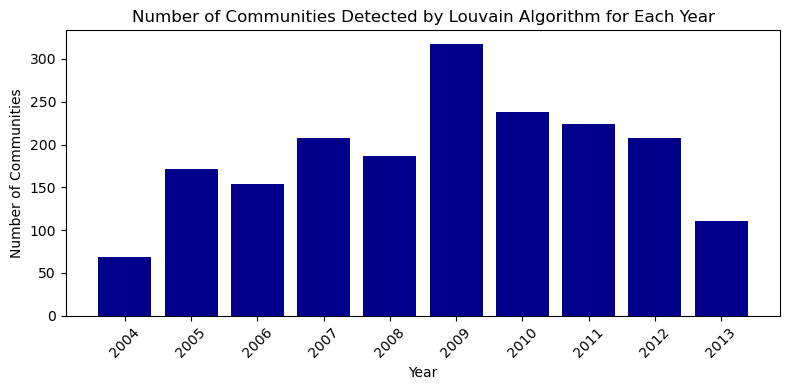

In [13]:
mean_size_communities = [np.mean([len(community) for community in communities]) for communities in louvain_communities]

plt.figure(figsize=(8, 4))
plt.bar(years[:-1], mean_size_communities, color='darkblue')
plt.xlabel('Year')
plt.ylabel('Number of Communities')
plt.title('Number of Communities Detected by Louvain Algorithm for Each Year')
plt.xticks(years[:-1], rotation=45)
plt.tight_layout()

plt.show()

We notice a great number of communities in our graph. To be able to more precisely explore those communities, we need tangible metrics to group users with, for this, we construct two types of graphs:<br>

-An Agreement Graph: This graph will represent the agreement between users within the DataFrame, meaning the similarity of their voting patterns in the election. This will allow us to understand whether there are communities of users who always vote similarly and whether those users tend to positively vote for each other.

-A Similarity Graph: This graph will represent how similarly users interact with Wikipedia content. We will build it using comments users write on articles' discussion pages. This will allow us to understand whether users who interact with the same type of content are more likely to vote positively for each other.

### Agreement Graph <a class="anchor" id="agreement-graph"></a>

We create a DataFrame containing the agreement between users. This agreement is calculated by first eliminating the neutral votes, and calculating the number of times two users voted in the same election, and extract the percentage of times they agreed.

We only keep pairs of users who voted in the same elections more than 10 times to have significant data and avoid outliers.

As the function takes too much time, we store its result in a '.csv' file that we directly load.

In [14]:
agreement_df_before_election = pd.read_csv('./data/agreement_before_election.csv')

In [15]:
filtered_agreement_df = agreement_df_before_election[agreement_df_before_election['Total Votes'] >= 10]

In [16]:
filtered_agreement_df

,USR1,USR2,Total Votes,Agreed,Total Votes before USR1 election,Total Votes before USR2 election,Agreed before USR1 election,Agreed before USR2 election,Agreement Ratio,Agreement Ratio before USR1 election,Agreement Ratio before USR2 election
263,INeverCry,Cncmaster,12,11,0,0,0,0,0.916667,NaN,NaN
264,INeverCry,Miniapolis,23,20,8,8,6,6,0.869565,0.750,0.750000
268,INeverCry,Carrite,19,16,8,7,6,5,0.842105,0.750,0.714286
269,INeverCry,Someguy1221,21,19,2,5,2,4,0.904762,1.000,0.800000
270,INeverCry,Secret,19,16,8,6,7,5,0.842105,0.875,0.833333
...,...,...,...,...,...,...,...,...,...,...,...
2387820,VeryVerily,Acegikmo1,11,4,0,0,0,0,0.363636,NaN,NaN
2388252,Cyp,Angela,10,9,0,0,0,0,0.900000,NaN,NaN
2388667,Dori,Texture,10,9,0,0,0,0,0.900000,NaN,NaN
2388979,Bcorr,Wile E. Heresiarch,10,6,0,1,0,1,0.600000,NaN,1.000000


We merge the obtained agreement DataFrame with the original wiki_df in order to study the correlation between the agreement ratio and the nature of the vote.

In [17]:
merged_wiki_df_1 = pd.merge(wiki_df, filtered_agreement_df, how='left', left_on=['SRC', 'TGT'], right_on=['USR1', 'USR2'])
merged_wiki_df_2 = pd.merge(wiki_df, filtered_agreement_df, how='left', left_on=['SRC', 'TGT'], right_on=['USR2', 'USR1'])

In [18]:
columns_to_keep = ['SRC', 'TGT', 'VOT', 'ELECTION_ID', 'Total Votes', 'Agreement Ratio',
                    'Total Votes before election', 'Agreement Ratio before election']

#Renaming columns
new_column_names_1 = {'Total Votes before USR1 election': 'Total Votes before election',
                    'Agreement Ratio before USR1 election': 'Agreement Ratio before election'}

new_column_names_2 = {'Total Votes before USR2 election': 'Total Votes before election',
                    'Agreement Ratio before USR2 election': 'Agreement Ratio before election'}

selected_df_1 = merged_wiki_df_1.rename(columns=new_column_names_1)
selected_df_2 = merged_wiki_df_2.rename(columns=new_column_names_2)

final_df_1 = selected_df_1.drop(selected_df_1.columns.difference(columns_to_keep), axis=1)
final_df_2 = selected_df_2.drop(selected_df_2.columns.difference(columns_to_keep), axis=1)

In [19]:
final_df = pd.concat([final_df_1, final_df_2])

In [20]:
final_df = final_df[final_df['Total Votes'] >= 10]

In [21]:
final_df

,SRC,TGT,VOT,ELECTION_ID,Total Votes,Total Votes before election,Agreement Ratio,Agreement Ratio before election
422,Morning Sunshine,INeverCry,1,4,16.0,2.0,0.812500,1.000
424,Torreslfchero,INeverCry,1,4,17.0,2.0,0.882353,1.000
450,Vacation9,INeverCry,1,4,12.0,8.0,0.833333,0.875
471,Joe Decker,INeverCry,1,4,19.0,1.0,0.894737,1.000
526,Inka 888,INeverCry,-1,4,10.0,0.0,0.800000,NaN
...,...,...,...,...,...,...,...,...
197997,Ambi,Squash,-1,3865,17.0,0.0,0.823529,NaN
198104,Hephaestos,Bcorr,1,3876,13.0,0.0,0.846154,NaN
198107,Ugen64,Bcorr,-1,3876,23.0,0.0,0.608696,NaN
198136,Angela,Dori,1,3885,18.0,0.0,0.944444,NaN


We investigate the distribution of the agreement ratio depending on the nature of the vote.

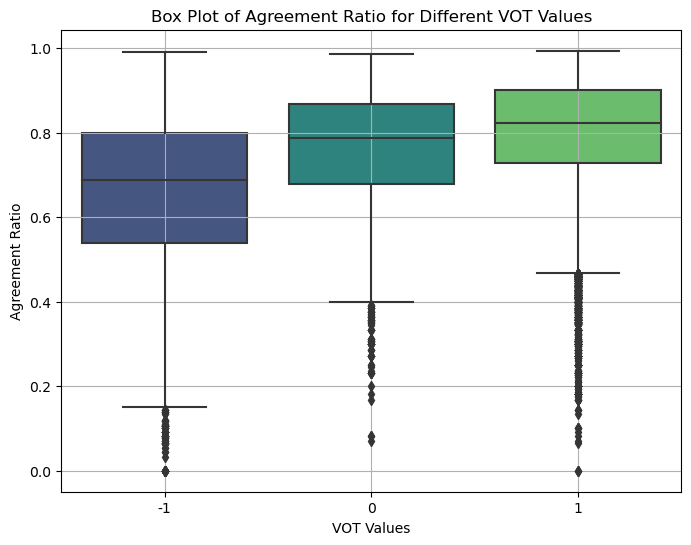

In [26]:
vot_values = [-1, 0, 1]
vot_data = [final_df[final_df['VOT'] == vot]['Agreement Ratio'] for vot in vot_values]

# Create box plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=vot_data, palette='viridis')

# Set labels and title
plt.xlabel('VOT Values')
plt.ylabel('Agreement Ratio')
plt.title('Box Plot of Agreement Ratio for Different VOT Values')

# Set x-axis tick labels
plt.xticks(range(len(vot_values)), vot_values)

# Show plot
plt.grid(True)
plt.show()

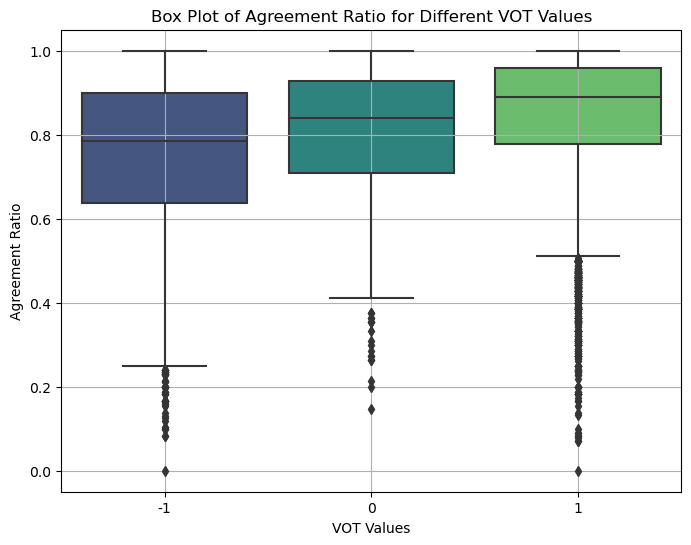

In [27]:
vot_values = [-1, 0, 1]
vot_data = [final_df[(final_df['VOT'] == vot) & (final_df['Total Votes before election'] >= 10)]['Agreement Ratio before election'] for vot in vot_values]

# Create box plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=vot_data, palette='viridis')

# Set labels and title
plt.xlabel('VOT Values')
plt.ylabel('Agreement Ratio')
plt.title('Box Plot of Agreement Ratio for Different VOT Values')

# Set x-axis tick labels
plt.xticks(range(len(vot_values)), vot_values)

# Show plot
plt.grid(True)
plt.show()

In [ ]:
vot_0 = final_df[final_df['VOT'] == 0]['Agreement Ratio']
vot_neg_1 = final_df[final_df['VOT'] == -1]['Agreement Ratio']
vot_1 = final_df[final_df['VOT'] == 1]['Agreement Ratio']

# Perform one-way ANOVA
f_statistic, p_value = f_oneway(vot_0, vot_neg_1, vot_1)

# Display results
print("F-Statistic:", f_statistic)
print("P-value:", p_value)

if p_value < 0.05:
    print("The differences between groups are statistically significant.")
else:
    print("There is no significant difference between groups.")

We can see that there are statistically significant differences between the three categories, positive votes have higher agreement ratios between the source and the target than neutral and negative votes.

We create an agreement graph: an edge exists between two users if they have voted in at least 10 elections together and have a higher agreement ratio than 0.9.

This will allows us to investigate whether there are communities who always vote similarly and whether members of those communities tend to positively vote for each other.

In [ ]:
graph_df = filtered_agreement_df[filtered_agreement_df['Agreement Ratio'] >= 0.9]

In [ ]:
G = nx.from_pandas_edgelist(graph_df, source='USR1', target='USR2')

In [ ]:
degrees = [G.degree(node) for node in G.nodes()]

#Plot the degree distribution
plt.hist(degrees, bins=40, alpha=0.7, color='darkblue', edgecolor='black')
plt.title('Degree Distribution of Agreement Graph')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

The structure of the agreement graph is similar to the structure of our initial graph, with most of the nodes having very low degrees while a minority of nodes has very high degrees.

Indeed, the presence of a node between two users is directly correlated to their number of votes, as we only select pairs that have voted together in at least 10 distinct elections, this makes users who have a very high number of votes more likely to have a very high degree.

In [ ]:
degrees = dict(G.degree())

sorted_degrees = sorted(degrees.items(), key=lambda x: x[1], reverse=True)
top_users = [user for user, _ in sorted_degrees[:5]]

print("Top 5 users with highest degrees:")
for node, degree in sorted_degrees[:5]:
    print(f"User {node}: Degree = {degree}")

In [ ]:
voters_df[voters_df['USER'].isin(top_users)]

We can see the users with the highest number of degrees have very high number of votes and are active through many years. This suggests they are more influential.

In [ ]:
betweenness_centrality = nx.betweenness_centrality(G)

sorted_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)
print("Top 5 nodes with highest betweenness centrality:")
for node, betweenness in sorted_betweenness[:5]:
    print(f"Node {node}: Betweenness Centrality = {betweenness}")

We notice that the same users have the highest Betweenness Centrality measure, indicating that those candidates are the most influential in the graph.

Using Louvain's algorithm, we try to detect communities in our graph and analyse the voting behavior and the agreement between the communities.

In [ ]:
communities = nx.community.louvain_communities(G)

In [ ]:
votes_received = []
votes_emitted = []

#Loop through each community
for community in communities:
    #Extract data for votes received and emitted by the community
    received_data = wiki_df[wiki_df['TGT'].isin(community)]
    emitted_data = wiki_df[wiki_df['SRC'].isin(community)]
    
    #Calculate the total number of votes received and emitted
    total_received = len(received_data)
    total_emitted = len(emitted_data)
    
    votes_received.append(total_received)
    votes_emitted.append(total_emitted)

#Create a bar plot for votes received and emitted for each community
plt.figure(figsize=(14, 6))
community_labels = [f'Community {i+1}' for i in range(len(communities))]

bar_width = 0.35
index = range(len(communities))

plt.bar(index, votes_received, bar_width, label='Votes Received')
plt.bar([i + bar_width for i in index], votes_emitted, bar_width, label='Votes Emitted')

plt.xlabel('Community')
plt.ylabel('Number of Votes')
plt.title('Total Votes Received and Emitted per Community')
plt.xticks([i + bar_width / 2 for i in index], community_labels)
plt.legend()

plt.tight_layout()
plt.show()

We notice that there are communities with a very low number of votes received and emitted, we eliminate those communities and only keep those with a significant number of votes emitted and received.

In [ ]:
communities = [communities[0], communities[5], communities[6], communities[8], communities[9]]

In [ ]:
pos_percentages = []
neg_percentages = []
neu_percentages = []

#Iterate through communities and calculate percentages for each vote type
for community in communities:
    community_votes = wiki_df[(wiki_df['SRC'].isin(community)) & (wiki_df['TGT'].isin(community))]
    
    total_count = len(community_votes)
    if total_count > 0:
        pos_count = len(community_votes[community_votes['VOT'] == 1]) / total_count * 100
        neg_count = len(community_votes[community_votes['VOT'] == -1]) / total_count * 100
        neu_count = len(community_votes[community_votes['VOT'] == 0]) / total_count * 100
    else:
        pos_count = 0
        neg_count = 0
        neu_count = 0
    
    #Append percentages for each vote type to respective lists
    pos_percentages.append(pos_count)
    neg_percentages.append(neg_count)
    neu_percentages.append(neu_count)
    
total_pos_percentage = len(wiki_df[wiki_df['VOT'] == 1]) / len(wiki_df) * 100
total_neg_percentage = len(wiki_df[wiki_df['VOT'] == -1]) / len(wiki_df) * 100
total_neu_percentage = len(wiki_df[wiki_df['VOT'] == 0]) / len(wiki_df) * 100
    
pos_percentages.append(total_pos_percentage)
neg_percentages.append(total_neg_percentage)
neu_percentages.append(total_neu_percentage)

#Create labels for the bar plot
labels = [f'Community {i+1}' for i in range(len(communities))]
labels.append('Total Votes')

#Create stacked bar plots for each community
plt.figure(figsize=(14, 8))

bar_width = 0.35
index = range(len(communities) + 1)

# Plotting stacked bars for each sentiment
plt.bar(index, pos_percentages, bar_width, label='Positive', color='green')
plt.bar(index, neu_percentages, bar_width, label='Neutral', color='blue', bottom=pos_percentages)
plt.bar(index, neg_percentages, bar_width, label='Negative', color='red', bottom=[pos + neu for pos, neu in zip(pos_percentages, neu_percentages)])

# Set x-axis ticks and labels
plt.xlabel('Community')
plt.ylim(0, 105)
plt.ylabel('Percentage')
plt.title('Vote Distribution for Each Community')
plt.xticks(index, [f'Community {i+1}' for i in range(len(communities))] + ['Total Votes'])
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
votes_received = []
votes_emitted = []

#Loop through each community
for community in communities:
    #Extract data for votes received and emitted by the community
    received_data = wiki_df[wiki_df['TGT'].isin(community)]
    emitted_data = wiki_df[wiki_df['SRC'].isin(community)]
    
    #Calculate the total number of votes received and emitted
    total_received = len(received_data)
    total_emitted = len(emitted_data)
    
    votes_received.append(total_received)
    votes_emitted.append(total_emitted)

#Create a bar plot for votes received and emitted for each community
plt.figure(figsize=(14, 6))
community_labels = [f'Community {i+1}' for i in range(len(communities))]

bar_width = 0.35
index = range(len(communities))

plt.bar(index, votes_received, bar_width, label='Votes Received')
plt.bar([i + bar_width for i in index], votes_emitted, bar_width, label='Votes Emitted')

plt.xlabel('Community')
plt.ylabel('Number of Votes')
plt.title('Total Votes Received and Emitted per Community')
plt.xticks([i + bar_width / 2 for i in index], community_labels)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
positive_votes = []
negative_votes = []
neutral_votes = []
total_votes_received = []

#Loop through each combination of communities
for community1 in communities:
    pos_row = []
    neg_row = []
    neu_row = []
    total_votes_row = []
    
    for community2 in communities:
        #Extract data based on community1 and community2
        src_data = wiki_df[wiki_df['SRC'].isin(community1)]
        tgt_data = wiki_df[wiki_df['TGT'].isin(community2)]
        filtered_data = src_data[src_data['TGT'].isin(community2)]
        
        total_count = len(filtered_data)
        if total_count > 0:
            #Calculate percentages of positive, negative, and neutral votes
            pos_count = len(filtered_data[filtered_data['VOT'] == 1]) / total_count * 100
            neg_count = len(filtered_data[filtered_data['VOT'] == -1]) / total_count * 100
            neu_count = len(filtered_data[filtered_data['VOT'] == 0]) / total_count * 100
        else:
            pos_count = 0
            neg_count = 0
            neu_count = 0
        
        pos_row.append(pos_count)
        neg_row.append(neg_count)
        neu_row.append(neu_count)
        
        # Calculate the total number of votes received by community1 from community2
        total_votes_row.append(total_count)
    
    positive_votes.append(pos_row)
    negative_votes.append(neg_row)
    neutral_votes.append(neu_row)
    total_votes_received.append(total_votes_row)

In [ ]:
agreement = []

#Loop through each combination of communities
for community1 in communities:
    agreement_row = []
    
    for community2 in communities:
        
        community1_agreement = filtered_agreement_df['USR1'].isin(community1) | filtered_agreement_df['USR2'].isin(community1)
        community2_agreement = filtered_agreement_df['USR1'].isin(community2) | filtered_agreement_df['USR2'].isin(community2)
        
        communities_agreement = filtered_agreement_df[community1_agreement & community2_agreement]
        
        agreement_row.append(np.mean(communities_agreement['Agreement Ratio']))
    
    
    agreement.append(agreement_row)

We plot heatmaps showing the distribution of positive, negative and neutral votes emitted from one community to another

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plotting the heatmaps
sns.heatmap(positive_votes, annot=True, cmap='Greens', fmt='.2f', ax=axes[0, 0])
axes[0, 0].set_title('Percentage of Positive Votes')
axes[0, 0].set_xlabel('Community 2')
axes[0, 0].set_ylabel('Community 1')

sns.heatmap(negative_votes, annot=True, cmap='Reds', fmt='.2f', ax=axes[0, 1])
axes[0, 1].set_title('Percentage of Negative Votes')
axes[0, 1].set_xlabel('Community 2')
axes[0, 1].set_ylabel('Community 1')

sns.heatmap(neutral_votes, annot=True, cmap='YlGnBu', fmt='.2f', ax=axes[1, 0])
axes[1, 0].set_title('Percentage of Neutral Votes')
axes[1, 0].set_xlabel('Community 2')
axes[1, 0].set_ylabel('Community 1')

sns.heatmap(total_votes_received, annot=True, cmap='YlGnBu', fmt='.2f', ax=axes[1, 1])
axes[1, 1].set_title('Number of Votes Received')
axes[1, 1].set_xlabel('Community 2')
axes[1, 1].set_ylabel('Community 1')

plt.tight_layout()
plt.show()

We notice a higher than average (>72.8%) percentage of positive votes in the diagonal, suggesting members of a community are more likely to positively vote for another member of the same community. We notice a higher percentage of positive votes between the community 0 and the community 1. We also notice a lower than average percentage of positive votes emitted from community 3 and 4 to community 0 and a high percentage of negative votes emitted between these communities.

We now plot the agreement between communities.

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(agreement, annot=True, cmap='Greens', fmt='.2f')
plt.title('Number of votes received')
plt.xlabel('Community 2')
plt.ylabel('Community 1')

We notice a very low agreement between community 3 and 4.

### Similarity Graph <a class="anchor" id="similarity-graph"></a>

We extract data corresponding to edits of discussion pages attached to each Wikipedia article) (https://snap.stanford.edu/data/wiki-meta.html) and group for each users the categories of articles they edited.

In [ ]:
import ast
###Data in stored as a text in .csv file, we need to cast it to a set
def set_converter(string):
    try:
        return ast.literal_eval(string) if isinstance(string, str) else set()
    except (ValueError, SyntaxError):
        return set()

talks_df = pd.read_csv(TALKS_DF, converters={'Categories': set_converter})

In [ ]:
talks_df['Article'] = talks_df['Article'].str.replace('Talk:', '')
talks_df_no_minor = talks_df[talks_df['Minor'] == 0]

In [ ]:
talks_df

In [ ]:
grouped_talks = talks_df.groupby(['User']).agg({
    'Article': lambda x: set(x),
    'Categories': lambda x: set.union(*x)
}).reset_index()

grouped_talks_no_minor = talks_df_no_minor.groupby(['User']).agg({
    'Article': lambda x: set(x),
    'Categories': lambda x: set.union(*x)
}).reset_index()

In [ ]:
grouped_talks

We only look at non minor edits as they are more informative than minor edits that could only consist of a small modification (such as correcting a small error).

We also only consider users who have casted at least 20 votes as this would give the most robust conclusions.

In [ ]:
more_than_20_votes_users = set(voters_df[voters_df['Votes Count'] > 20]['USER'])
grouped_talks_no_minor = grouped_talks_no_minor[grouped_talks_no_minor['User'].isin(more_than_20_votes_users)]

In [ ]:
grouped_talks_no_minor

We compute the Jaccard similarity between each pair of users' categories and articles.

In [ ]:
from tqdm import tqdm

user_pairs = []
articles_similarities = []
categories_similarities = []
articles_intersections = []
categories_intersections = []


def calculate_jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union > 0 else 0


for user1, user2 in tqdm(combinations(grouped_talks_no_minor['User'], 2), total=len(list(combinations(grouped_talks_no_minor['User'], 2)))):
    user1_entry = grouped_talks_no_minor[grouped_talks_no_minor['User'] == user1]
    user2_entry = grouped_talks_no_minor[grouped_talks_no_minor['User'] == user2]
    
    articles_user1 = user1_entry['Article'].iloc[0]
    articles_user2 = user2_entry['Article'].iloc[0]
        
    categories_user1 = user1_entry['Categories'].iloc[0]
    categories_user2 = user2_entry['Categories'].iloc[0]
        
    articles_similarity = calculate_jaccard_similarity(articles_user1, articles_user2)
    categories_similarity = calculate_jaccard_similarity(categories_user1, categories_user2)
    articles_intersection = len(articles_user1.intersection(articles_user2))
    categories_intersection = len(categories_user1.intersection(categories_user2))
    
        
    articles_intersections.append(articles_intersection)
    categories_intersections.append(categories_intersection)
    user_pairs.append((user1, user2))
    articles_similarities.append(articles_similarity)
    categories_similarities.append(categories_similarity)
        
# Create a DataFrame for Jaccard similarities
df_jaccard_similarity = pd.DataFrame({
    'User1': [pair[0] for pair in user_pairs],
    'User2': [pair[1] for pair in user_pairs],
    'Article Similarity': articles_similarities,
    'Categories Similarity': categories_similarities,
    'Categories Intersection': categories_intersections,
    'Articles Intersection': articles_intersections
})

In [ ]:
df_jaccard_similarity

We first create a graph where edges between users are weighted by the number of common articles they have.

In [ ]:
similarity_graph = nx.from_pandas_edgelist(df_jaccard_similarity[df_jaccard_similarity['Articles Intersection'] > 10], 'User1', 'User2', edge_attr='Articles Intersection', create_using= nx.Graph())

In [ ]:
print('Number of nodes:', similarity_graph.number_of_nodes())
print('Number of edges:', similarity_graph.number_of_edges())
print('Graph density:', nx.density(similarity_graph))

In [ ]:
degrees = [similarity_graph.degree(node) for node in similarity_graph.nodes()]

#Plot the degree distribution
plt.hist(degrees, bins=40, alpha=0.7, color='darkblue', edgecolor='black')
plt.title('Degree Distribution of Similarity Graph')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
communities = nx.community.louvain_communities(similarity_graph)

In [ ]:
len(communities)

In [ ]:
from collections import Counter

community_category_counts = {}

for idx, community in enumerate(communities):
    community_category_counts[idx] = Counter()
    for user in community:
        user_categories = grouped_talks_no_minor[grouped_talks_no_minor['User'] == user]['Article'].iloc[0]
        community_category_counts[idx] += Counter(user_categories)

    #Print top 10 categories for this community
    print(f"Community {idx + 1}:")
    top_categories = community_category_counts[idx].most_common(15)
    for category, count in top_categories:
        print(f"Category: {category}, Count: {count}")
    print()

We can see that there are themes we can associate to each community. <br>
Community 1: Music <br>
Community 2: World History <br>
Community 3: American History <br>
Community 4: India <br>
Community 5: Religion / Conspiracionism <br>
Community 6: Judaism <br>
Community 7: Sport <br>
Community 8: Pop Culture / Video Games <br>
Community 9: American Hurricanes / Disasters <br>
Community 10: Poker <br>

Let's analyze voting patterns and agreement between each community, similar to what we did before.

In [ ]:
votes_received = []
votes_emitted = []

#Loop through each community
for community in communities:
    #Extract data for votes received and emitted by the community
    received_data = wiki_df[wiki_df['TGT'].isin(community)]
    emitted_data = wiki_df[wiki_df['SRC'].isin(community)]
    
    #Calculate the total number of votes received and emitted
    total_received = len(received_data)
    total_emitted = len(emitted_data)
    
    votes_received.append(total_received)
    votes_emitted.append(total_emitted)

#Create a bar plot for votes received and emitted for each community
plt.figure(figsize=(14, 6))
community_labels = [f'Community {i+1}' for i in range(len(communities))]

bar_width = 0.35
index = range(len(communities))

plt.bar(index, votes_received, bar_width, label='Votes Received')
plt.bar([i + bar_width for i in index], votes_emitted, bar_width, label='Votes Emitted')

plt.xlabel('Community')
plt.ylabel('Number of Votes')
plt.title('Total Votes Received and Emitted per Community')
plt.xticks([i + bar_width / 2 for i in index], community_labels)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
pos_percentages = []
neg_percentages = []
neu_percentages = []

#Iterate through communities and calculate percentages for each vote type
for community in communities:
    community_votes = wiki_df[(wiki_df['SRC'].isin(community)) & (wiki_df['TGT'].isin(community))]
    
    total_count = len(community_votes)
    if total_count > 0:
        pos_count = len(community_votes[community_votes['VOT'] == 1]) / total_count * 100
        neg_count = len(community_votes[community_votes['VOT'] == -1]) / total_count * 100
        neu_count = len(community_votes[community_votes['VOT'] == 0]) / total_count * 100
    else:
        pos_count = 0
        neg_count = 0
        neu_count = 0
    
    #Append percentages for each vote type to respective lists
    pos_percentages.append(pos_count)
    neg_percentages.append(neg_count)
    neu_percentages.append(neu_count)
    
total_pos_percentage = len(wiki_df[wiki_df['VOT'] == 1]) / len(wiki_df) * 100
total_neg_percentage = len(wiki_df[wiki_df['VOT'] == -1]) / len(wiki_df) * 100
total_neu_percentage = len(wiki_df[wiki_df['VOT'] == 0]) / len(wiki_df) * 100
    
pos_percentages.append(total_pos_percentage)
neg_percentages.append(total_neg_percentage)
neu_percentages.append(total_neu_percentage)

labels = [f'Community {i+1}' for i in range(len(communities))]
labels.append('Total Votes')

plt.figure(figsize=(14, 8))

index = range(len(communities) + 1)

plt.bar(index, pos_percentages, bar_width, label='Positive', color='green')
plt.bar(index, neu_percentages, bar_width, label='Neutral', color='blue', bottom=pos_percentages)
plt.bar(index, neg_percentages, bar_width, label='Negative', color='red', bottom=[pos + neu for pos, neu in zip(pos_percentages, neu_percentages)])

plt.xlabel('Community')
plt.ylim(0, 105)
plt.ylabel('Percentage')
plt.title('Vote Distribution for Each Community')
plt.xticks(index, [f'Community {i+1}' for i in range(len(communities))] + ['Total Votes'])
plt.legend()
plt.tight_layout()

# Show plot
plt.show()

We notice that within a community, there are higher positive votes than average. Howerver, this should be taken with a grain of salt as the number of candidates, and therefore the number of votes received by a candidate from other members of its community, vary from one community to the other.

### Conclusion

Our graph analysis shows that voter behavior toward a candidate is influenced by more than just their work or achievements. Affinity plays a crucial role in shaping these voting patterns. When a candidate aligns closely with a voter's voting behavior, it significantly increases the likelihood of receiving a positive vote from that individual, and conversely, dissimilarity often leads to negative votes.

Moreover, our analysis highlights the existence of distinct user communities. These communities tend to engage more with specific content types, either for personal interests or expertise in certain domains like sports, politics, or video games. Within these communities, there's a heightened tendency for individuals to support one another by casting positive votes, creating an environment where mutual affinity strongly influences voting tendencies.